In [31]:
import os

import pandas as pd
import numpy as np

import category_encoders as ce

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor, LGBMClassifier,  plot_importance

from sklearn.linear_model import LinearRegression

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression

from skopt import forest_minimize

from modelling_functions import ModelTrainer, split_data, validation, compare_results

import warnings
warnings.filterwarnings("ignore")

Para evitar problemas de bairros com mesmo nome (como Centro) em municípios diferentes, iremos mesclar as duas variáveis em uma só e usar um labelencoder nela

In [3]:
data_path = os.path.join('..','data','01_raw','data.csv')
df = pd.read_csv(data_path)

df['municipio']=df['municipio'].str.replace(' ','_')
df['bairro']=df['bairro'].str.replace(' ','_')
df['bairro'] = df['bairro'].fillna('')
df['municipio+bairro'] = df['municipio']+'_'+df['bairro']

df = df.rename(columns={'stone_tpv_acquirer_total':'target'})

In [4]:

le = LabelEncoder()

for col in ['uf','municipio+bairro']:
    df[col] = le.fit_transform(df[col])

In [5]:
list(df)

['target',
 'cnae_fiscal_principal',
 'segmento',
 'uf',
 'municipio',
 'bairro',
 'mei',
 'capital_social',
 'total_estab',
 'mcc',
 'subsegmento',
 'porte',
 'faixa_empregados',
 'tier',
 'municipio+bairro']

## Criando um Baseline

Iniciaremos os testes criando um modelo simples de regressão para termos idéia de como os dados crus ajudam na previsão do alvo.

Utilizaremos em todos os testes o modelo Lightgbm por geralmente ser um bom modelo para dados tabulares e de rápida execução.

Para o baseline também utilizaremos um modelo de regressão linear simples para fins comparativos.

In [5]:
df_baseline = df.copy().drop(columns=['municipio','bairro'])

Separaremos 50% dos nossos dados para teste do modelo após a conclusão dele.

Já para treino e validação, treinaremos com 70% dos dados e validaremos com 30%

In [119]:
# Vamos dividir os dados em três: treino, validação e teste, onde o conjunto de teste sera um conjunto de dados totalmente novos
# e que não serão utilizados no treino e otimização
X, X_train, X_val, X_test, y, y_train, y_val, y_test = split_data(df_baseline,'target', train_frac =  0.7, val_frac = 0.5)

In [120]:
lr = LinearRegression()
lgb = LGBMRegressor(random_state=42,n_estimators=100, verbose=-1)

In [121]:
lr_reg = ModelTrainer(lr)
lgbm_reg = ModelTrainer(lgb)

In [123]:
model_baseline_lr = lr_reg.train(X_train,y_train)
test_baseline_lr = validation(X_test,y_test,lr_reg, 'test')
val_baseline_lr =  validation(X_val,y_val,lr_reg, 'val')

In [40]:
compare_results(val_baseline_lr,test_baseline_lr)

,r2_score,RMSE,MAE,MAE/Mean(%),RMSE/STD (%)
val,0.119144,78545.152233,33202.695092,86.80,93.85
test,0.083285,105026.628795,34049.665525,86.11,95.74


In [37]:
model_baseline_lgb = lgbm_reg.train(X_train,y_train)
test_baseline_lgb = validation(X_test,y_test,lgbm_reg, 'test')
val_baseline_lgb = validation(X_val,y_val,lgbm_reg, 'val')

In [42]:
compare_results(val_baseline_lgb,test_baseline_lgb)

,r2_score,RMSE,MAE,MAE/Mean(%),RMSE/STD (%)
val,0.233410,73273.759345,27773.793785,72.60,87.55
test,0.196455,98330.302411,28862.148352,72.99,89.64


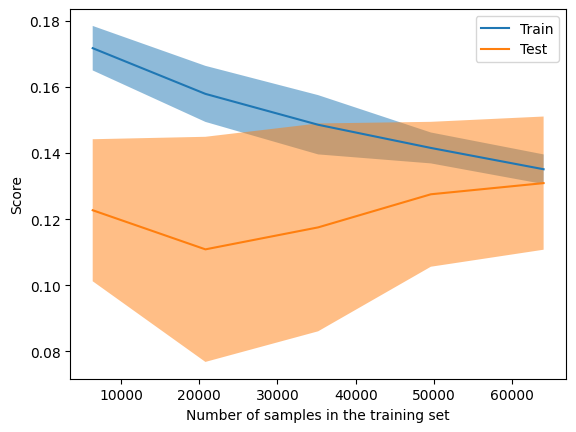

In [13]:
lr_reg.learning_check(X,y)

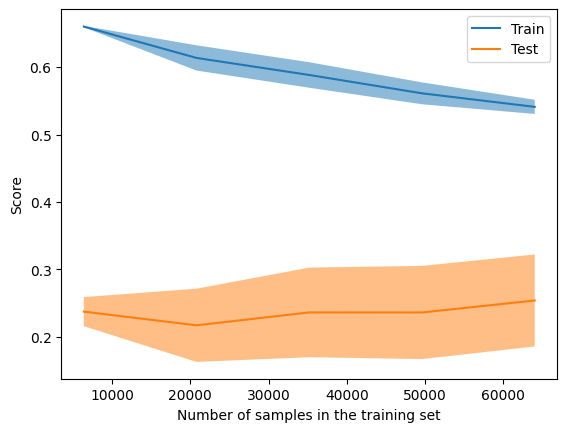

In [14]:
lgbm_reg.learning_check(X,y)

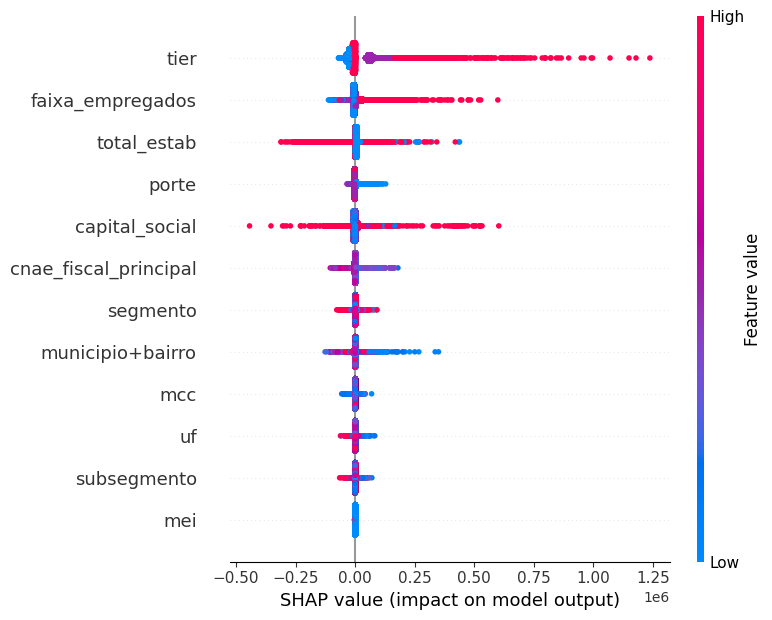

In [15]:
lgbm_reg.interpret(X)

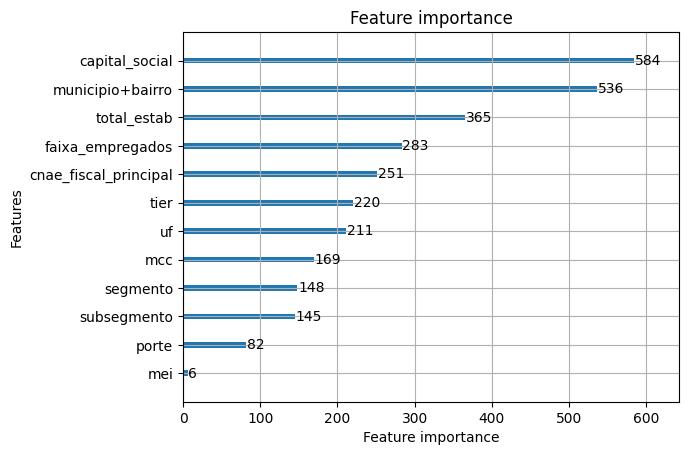

In [16]:
plot_importance(lgbm_reg.model)
plt.show()

**Conclusões**
* De forma geral nenhum dos dois modelos apresentou boa performance, mas o LightGBM se mostrou superior ao Linear (como esperado)
* Sobre as variáveis independentes:
    * Tier se mostrou mais relevante individualmente para definir valores altos do TPV (o que faz sentido)
    * Capital Social por outro lado foi a variavel mais importante no ambito geral
* Necessário checarmos se há necessidade de criação ou transformação de novas variáveis
* Outra possibilidade que não exploraremos nestes testes será a inclusão de variáveis externas

## Teste: Criação de Variáveis

Vamos criar uma variável nova manualmente e checar o efeito de sua presença no modelo

In [14]:
df_new = df.copy()

In [15]:
df_new.head()

,target,cnae_fiscal_principal,segmento,uf,municipio,bairro,mei,capital_social,total_estab,mcc,subsegmento,porte,faixa_empregados,tier,municipio+bairro
0,4764.00,428,5,25,MAUA,VILA_BOCAINA,0,100000,1,163,31,2,0,0,16099
1,23929.99,309,2,25,SAO_PAULO,VILA_BARUEL,0,10000,1,95,3,2,1,2,25592
2,6225.50,369,0,10,SAO_JOSE_DA_LAPA,DOM_PEDRO_I,1,1000,1,59,13,3,0,0,23915
3,35448.28,280,0,16,TERESINA,PRIMAVERA,0,100000,1,57,13,2,1,2,27619
4,13848.26,300,16,8,MINEIROS,SAO_JOAO,0,10000,1,46,48,2,0,0,16227


Como vimos na seção anterior que tier é uma variável relevante para explicação do modelo, iremos criar manualmente uma nova variável baseada nela

In [16]:
df_new['tier_por_porte'] = (df_new['tier']+1)/(df_new['porte']+1)

In [17]:
df_new.head()

,target,cnae_fiscal_principal,segmento,uf,municipio,bairro,mei,capital_social,total_estab,mcc,subsegmento,porte,faixa_empregados,tier,municipio+bairro,tier_por_porte
0,4764.00,428,5,25,MAUA,VILA_BOCAINA,0,100000,1,163,31,2,0,0,16099,0.333333
1,23929.99,309,2,25,SAO_PAULO,VILA_BARUEL,0,10000,1,95,3,2,1,2,25592,1.000000
2,6225.50,369,0,10,SAO_JOSE_DA_LAPA,DOM_PEDRO_I,1,1000,1,59,13,3,0,0,23915,0.250000
3,35448.28,280,0,16,TERESINA,PRIMAVERA,0,100000,1,57,13,2,1,2,27619,1.000000
4,13848.26,300,16,8,MINEIROS,SAO_JOAO,0,10000,1,46,48,2,0,0,16227,0.333333


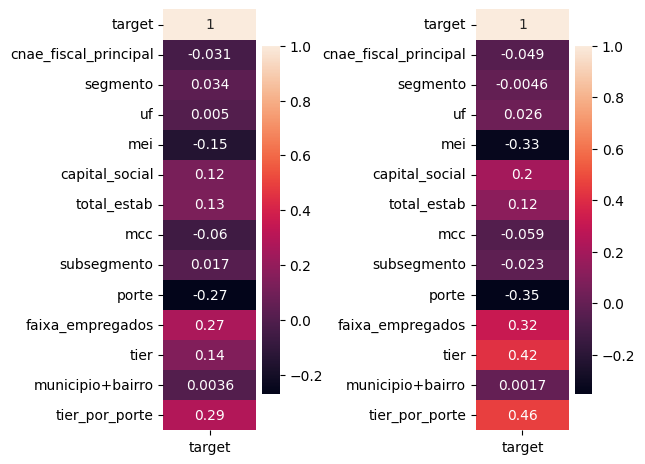

In [18]:
#Checando correlações com a variável alvo
plt.subplot(1,2,1)
sns.heatmap(df_new.drop(columns=['municipio','bairro']).corr('pearson')[['target']],annot=True)
plt.subplot(1,2,2)
sns.heatmap(df_new.drop(columns=['municipio','bairro']).corr('spearman')[['target']],annot=True)
plt.tight_layout()
plt.show()

In [19]:
# Checando informação Mútua
mi_scores = mutual_info_regression(df_new.drop(columns=['municipio','bairro']), df_new['target'])

pd.DataFrame(data={'Feature': df_new.drop(columns=['municipio','bairro']).columns, 'MI Score': mi_scores}).sort_values('MI Score', ascending = False).drop(0)

,Feature,MI Score
11,tier,0.246310
13,tier_por_porte,0.222480
9,porte,0.085826
10,faixa_empregados,0.072237
4,mei,0.063446
1,cnae_fiscal_principal,0.038748
7,mcc,0.032879
8,subsegmento,0.030051
5,capital_social,0.022895
2,segmento,0.022878


Com análise de Correlações e Informação Mútua concluimos que a variável alvo não possui dependência forte com nenhuma variável, apenas dependência moderada com tier e tier_por_porte.

Vamos checar como nossa nova variável influência o modelo, mas não devemos esperar grandes melhorias.

In [20]:
df_new = df_new.drop(columns=['municipio','bairro'])

In [53]:
# Realizando novo split com a adição da nova variável
X, X_train, X_val, X_test, y, y_train, y_val, y_test = split_data(df_new,'target')

In [54]:
lgb_nf = ModelTrainer(LGBMRegressor(random_state=42, n_estimators=100, verbose=-1))

In [55]:
lgb_nf.train(X_train,y_train)

LGBMRegressor(random_state=42, verbose=-1)

In [62]:
val_new_feature = validation(X_val,y_val,lgb_nf,'val')
test_new_feature = validation(X_test,y_test,lgb_nf,'test')

In [65]:
compare_results(val_new_feature,test_new_feature)

,r2_score,RMSE,MAE,MAE/Mean(%),RMSE/STD (%)
val,0.279255,76285.206238,27851.383093,72.03,84.90
test,0.210978,95970.222717,29421.175633,73.57,88.83


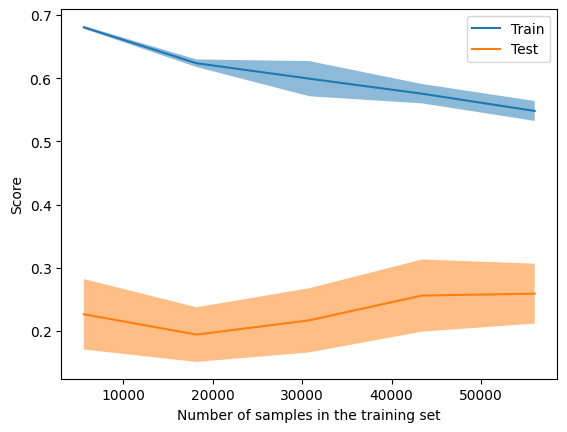

In [66]:
lgb_nf.learning_check(X,y)

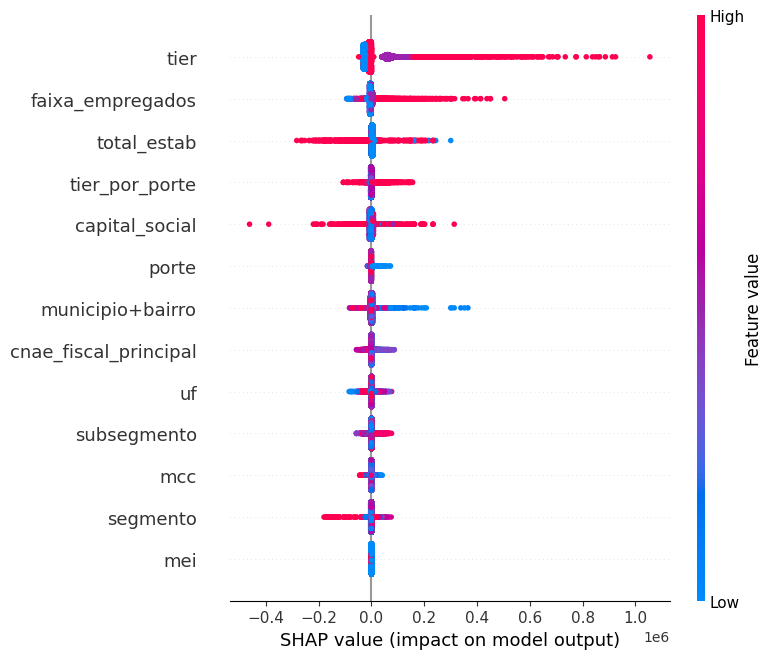

In [67]:
lgb_nf.interpret(X)

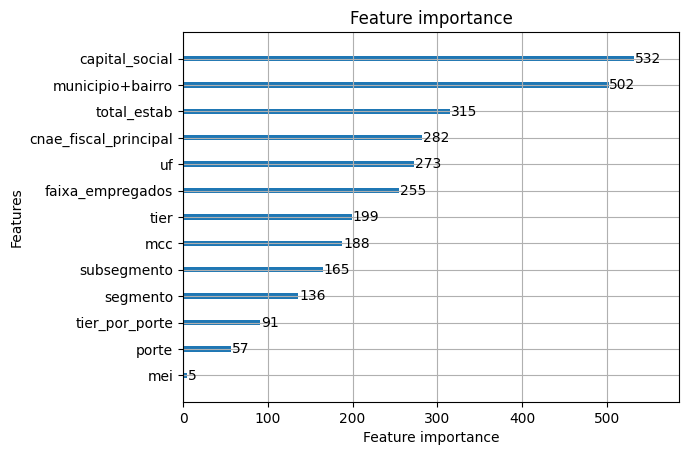

In [68]:
plot_importance(lgb_nf.model)
plt.show()

**Conclusões**
* A inclusão da nova variável melhorou um pouco o desempenho do modelo
* Isso abre margem para pensarmos em novas variáveis que combinem as variáveis que possuimos, em particular, focar em variáveis que façam sentido dentro do negócio poderiam auxiliar na previsão, mas não abordaremos isso aqui

## Teste: Transformações

### One-Hot-Encoding

Como possuimos diversas variáveis categóricas, iremos aplicar a técnica de one-hot encoding para as que possuem menos categorias.

Combinaremos isso com nossa nova variável tier_por_porte

In [69]:
df_ohe = df_new.copy()

Das variáveis que possuimos iremos aplicar a técnica de OHE em:
* segmento
* uf
* porte
* faixa_empregados
* tier

In [70]:
df_encoded = pd.get_dummies(df_ohe, columns=['uf', 'segmento','porte','faixa_empregados','tier'])

In [71]:
df_encoded.head()

,target,cnae_fiscal_principal,mei,capital_social,total_estab,mcc,subsegmento,municipio+bairro,tier_por_porte,uf_0,...,faixa_empregados_0,faixa_empregados_1,faixa_empregados_2,faixa_empregados_3,faixa_empregados_4,tier_0,tier_1,tier_2,tier_3,tier_4
0,4764.00,428,0,100000,1,163,31,16099,0.333333,False,...,True,False,False,False,False,True,False,False,False,False
1,23929.99,309,0,10000,1,95,3,25592,1.000000,False,...,False,True,False,False,False,False,False,True,False,False
2,6225.50,369,1,1000,1,59,13,23915,0.250000,False,...,True,False,False,False,False,True,False,False,False,False
3,35448.28,280,0,100000,1,57,13,27619,1.000000,False,...,False,True,False,False,False,False,False,True,False,False
4,13848.26,300,0,10000,1,46,48,16227,0.333333,False,...,True,False,False,False,False,True,False,False,False,False


In [72]:
# Novo split
X, X_train, X_val, X_test, y, y_train, y_val, y_test = split_data(df_encoded, 'target')

In [79]:
lgb_ohe = ModelTrainer(LGBMRegressor(random_state=42,n_estimators=100, verbose=-1))
lgb_ohe.train(X_train,y_train)
val_ohe = validation(X_val,y_val,lgb_ohe,'val')
test_ohe = validation(X_test,y_test,lgb_ohe,'test')


In [83]:
compare_results(val_new_feature,test_new_feature)

,r2_score,RMSE,MAE,MAE/Mean(%),RMSE/STD (%)
val,0.279255,76285.206238,27851.383093,72.03,84.90
test,0.210978,95970.222717,29421.175633,73.57,88.83


In [82]:
compare_results(val_ohe,test_ohe)

,r2_score,RMSE,MAE,MAE/Mean(%),RMSE/STD (%)
val,0.278313,76335.041671,27801.303755,71.90,84.95
test,0.239944,94192.151716,29245.613517,73.13,87.18


* Notamos uma melhora nas métricas, mas nosso modelo ainda não está bom o suficiente
* Utilizaremos outras técnicas para as variáveis categóricas com muitas classes

### CountEncoder

Para as variáveis com muitas categorias utilizaremos um encoder de frequência com que aparecem:
As variáveis serão:
* Subsegmento
* cnae_fiscal_principa
* mcc
* municipio+bairro

In [85]:
freq_encoder = ce.CountEncoder()

In [86]:
df_encoded_freq = df_encoded.copy()

In [87]:
df_encoded_freq[['subsegmento','cnae_fiscal_principal','mcc','municipio+bairro']] = df_encoded_freq[['subsegmento','cnae_fiscal_principal','mcc','municipio+bairro']].astype('category')

In [88]:
df_encoded_freq[['subsegmento_encoded','cnae_encoded','mcc_encoded','bairro_encoded']] = freq_encoder.fit_transform(df_encoded_freq[['subsegmento','cnae_fiscal_principal','mcc','municipio+bairro']])

In [90]:
df_encoded_freq.head()

,target,cnae_fiscal_principal,mei,capital_social,total_estab,mcc,subsegmento,municipio+bairro,tier_por_porte,uf_0,...,faixa_empregados_4,tier_0,tier_1,tier_2,tier_3,tier_4,subsegmento_encoded,cnae_encoded,mcc_encoded,bairro_encoded
0,4764.00,428,0,100000,1,163,31,16099,0.333333,False,...,False,True,False,False,False,False,1016,235,966,8
1,23929.99,309,0,10000,1,95,3,25592,1.000000,False,...,False,False,False,True,False,False,999,649,855,7
2,6225.50,369,1,1000,1,59,13,23915,0.250000,False,...,False,True,False,False,False,False,10771,1535,5496,1
3,35448.28,280,0,100000,1,57,13,27619,1.000000,False,...,False,False,False,True,False,False,10771,294,294,1
4,13848.26,300,0,10000,1,46,48,16227,0.333333,False,...,False,True,False,False,False,False,5899,2234,2941,4


In [95]:
df_encoded_freq = df_encoded_freq.drop(columns = ['subsegmento','cnae_fiscal_principal','mcc','municipio+bairro'])

In [96]:
# Novo split
X, X_train, X_val, X_test, y, y_train, y_val, y_test = split_data(df_encoded_freq, 'target')

In [97]:
lgb_freq = ModelTrainer(LGBMRegressor(random_state=42,n_estimators=100, verbose=-1))
lgb_freq.train(X_train,y_train)
val_freq = validation(X_val,y_val,lgb_freq,'val')
test_freq = validation(X_test,y_test,lgb_freq,'test')

In [98]:
compare_results(val_ohe,test_ohe)

,r2_score,RMSE,MAE,MAE/Mean(%),RMSE/STD (%)
val,0.278313,76335.041671,27801.303755,71.90,84.95
test,0.239944,94192.151716,29245.613517,73.13,87.18


In [99]:
compare_results(val_freq,test_freq)

,r2_score,RMSE,MAE,MAE/Mean(%),RMSE/STD (%)
val,0.274164,76554.120993,27730.075512,71.71,85.19
test,0.230380,94782.928832,29191.569094,72.99,87.73


**Conclusões**
* Infelizmente esta técnica de encoding não propiciou nenhuma melhora significativa no modelo
* Outras técnicas poderiam ser utilizadas, mas dada a natureza do problema e a baixa influência das variáveis independentes com a variável alvo, vamos utilizar outra técnica

## Mudando o problema para Classificação

Vamos mudar o escopo do problema: ao invés de prever valores continuos para o TPV iremos separa-lo em intervalos e tentaremos classificar esses intervalos usando nossas variáveis.

In [21]:
df_cf = df_new.copy()

In [22]:
conditions = [
    (df_cf['target'] <= 100),
    (df_cf['target'] <= 1000),
    (df_cf['target'] <= 10000),
    (df_cf['target'] <= 100000),
    (df_cf['target'] > 100000)
]

values = [0, 1, 2, 3, 4]

# Criar a coluna 'target_class' com base nas condições e valores
df_cf['target_class'] = np.select(conditions, values)

df_cf['target_class'].value_counts()

target_class
3    56735
2    28047
4     8256
1     5287
0     1675
Name: count, dtype: int64

In [23]:
df_cf.head()

,target,cnae_fiscal_principal,segmento,uf,mei,capital_social,total_estab,mcc,subsegmento,porte,faixa_empregados,tier,municipio+bairro,tier_por_porte,target_class
0,4764.00,428,5,25,0,100000,1,163,31,2,0,0,16099,0.333333,2
1,23929.99,309,2,25,0,10000,1,95,3,2,1,2,25592,1.000000,3
2,6225.50,369,0,10,1,1000,1,59,13,3,0,0,23915,0.250000,2
3,35448.28,280,0,16,0,100000,1,57,13,2,1,2,27619,1.000000,3
4,13848.26,300,16,8,0,10000,1,46,48,2,0,0,16227,0.333333,3


In [24]:
categorical_list = list(df_cf.drop(columns=['capital_social','total_estab','target_class','target']))
df_cf[categorical_list] = df_cf[categorical_list].astype('category')
df_cf['target_class'] = df_cf['target_class'].astype('category')

In [25]:
X, X_train, X_val, X_test, y, y_train, y_val, y_test = split_data(df_cf.drop(columns='target'),'target_class')

In [160]:
lgb_cf = ModelTrainer(LGBMClassifier(random_state=42, objective='multiclass', n_estimators=250, class_weight='balanced', verbose=-1))
lgb_cf.train(X_train,y_train)

LGBMClassifier(class_weight='balanced', n_estimators=250,
               objective='multiclass', random_state=42, verbose=-1)

In [161]:
val_lgb_cf = validation(X_val,y_val,lgb_cf,'val',multi=True)
test_lgb_cf = validation(X_test,y_test,lgb_cf,'test',multi=True)
compare_results(val_lgb_cf,test_lgb_cf)

,Accuracy,Precision,Recall,F1 Score,ROC-AUC
val,0.552429,0.604642,0.552429,0.571285,0.714040
test,0.546100,0.597921,0.546100,0.564612,0.707488


In [162]:
print(classification_report(y_test,lgb_cf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.03      0.07      0.04       462
           1       0.08      0.11      0.10      1630
           2       0.48      0.54      0.51      8352
           3       0.74      0.59      0.66     17061
           4       0.43      0.63      0.51      2495

    accuracy                           0.55     30000
   macro avg       0.35      0.39      0.36     30000
weighted avg       0.60      0.55      0.56     30000



In [163]:
pd.DataFrame(confusion_matrix(lgb_cf.predict(X_test),y_test))

,0,1,2,3,4
0,31,79,444,627,48
1,67,181,867,1005,58
2,181,816,4520,3757,87
3,134,453,2161,10070,721
4,49,101,360,1602,1581


**Conclusões**
* O classificador conseguiu extrair melhor algum padrão e relação entre as variáveis dependentes e o intervalo de classificação
* Arbitrariamente decidimos utilizar 5 categorias, mas estas poderiam ser reduzidas ou aumentadas de acordo com a necessidade
* Vamos seguir com esse modelo e focar em melhorar esta modelagem de intervalos para o TPV

## Otimização do Modelo

### Modelo de Classificação

In [26]:
X, X_train, X_val, X_test, y, y_train, y_val, y_test = split_data(df_cf.drop(columns='target'),'target_class',stratified=True)

In [32]:
def tune_lgbm(params):
    
    lr = params[0]
    max_depth = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    n_estimators = params[5]
    reg_alpha = params[6]
    reg_lambda = params[7]
    gamma = params[8]
    
    
    model = LGBMClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth, 
                         min_child_samples=min_child_samples, subsample=subsample,
                         colsample_bytree=colsample_bytree, bagging_freq=1,n_estimators=n_estimators, 
                         reg_alpha =reg_alpha, reg_lambda=reg_lambda, gamma=gamma,
                         random_state=0,class_weight="balanced", objective='multiclass',verbose=-1)
    model.fit(X_train, y_train)
    
    p = model.predict(X_val)
    f1_macro = f1_score(y_val, p, average='macro')
    
    f1_weighted = f1_score(y_val, p, average='weighted')

    return -f1_weighted

In [33]:
space = [(1e-3, 1e-1, 'log-uniform'), # lr
          (1, 10), # max_depth
          (1, 20), # min_child_samples
          (0.05, 1.), # subsample
          (0.05, 1.), # colsample_bytree
          (100,1000),# n_estimator
          (1e-6,1, 'log-uniform'), #reg_alpha
          (1e-6,1, 'log-uniform'),#reg_lambda
          (0,5)] #gamma

In [34]:
res = forest_minimize(tune_lgbm, space, random_state=42, n_random_starts=10, n_calls=10, verbose=0)

In [35]:
res.x

[0.013383707472536775,
 10,
 9,
 0.06516793960920349,
 0.2693491343410416,
 191,
 0.0004374364439939081,
 5.397956855996451e-06,
 4]

In [332]:
best_params = res.x

In [333]:
lr = best_params[0]
max_depth = best_params[1]
min_child_samples = best_params[2]
subsample = best_params[3]
colsample_bytree = best_params[4]
n_estimators = best_params[5]
reg_alpha = best_params[6]
reg_lambda = best_params[7]
gamma = best_params[8]

clf_opt = ModelTrainer(LGBMClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth, 
                         min_child_samples=min_child_samples, subsample=subsample,
                         colsample_bytree=colsample_bytree, bagging_freq=1,n_estimators=n_estimators, 
                         reg_alpha =reg_alpha, reg_lambda=reg_lambda, gamma=gamma,
                         random_state=0,class_weight="balanced", objective='multiclass',verbose=-1))

In [334]:
clf_opt.train(X_train,y_train)

LGBMClassifier(bagging_freq=1, class_weight='balanced',
               colsample_bytree=0.9120261407249445, gamma=0,
               learning_rate=0.001880442371319623, max_depth=8,
               n_estimators=159, num_leaves=256, objective='multiclass',
               random_state=0, reg_alpha=0.00108470587515549,
               reg_lambda=0.17947227414460606, subsample=0.057483641559810464,
               verbose=-1)

In [348]:
val_clf_opt = validation(X_val,y_val,clf_opt,'val',multi=True)
test_clf_opt = validation(X_test,y_test,clf_opt,'test',multi=True)
compare_results(val_clf_opt,test_clf_opt)

,Accuracy,Precision,Recall,F1 Score,ROC-AUC
val,0.604886,0.620304,0.604886,0.603412,0.727811
test,0.601267,0.617997,0.601267,0.600647,0.724216


In [349]:
pd.DataFrame(confusion_matrix(y_test,clf_opt.predict(X_test)))

,0,1,2,3,4
0,36,10,217,148,51
1,64,40,928,490,108
2,377,205,5240,2144,386
3,434,121,3920,10919,1667
4,10,2,57,623,1803


**Conclusões**
* A versão de classificação do modelo aparenta ter uma performance bem superior ao modelo de regressão, mas ainda assim é um modelo de desempenho mediano
* Possíveis otimizações podem ser feitas como, por exemplo, a busca por limiares ótimos para a classificação, principalmente para as classes 0 e 1

## Considerações Finais


* O dataset disponibilizado em sua forma bruta não parece ter dados otimizados para a previsão do TPV como variável contínua
* A criação de novas variáveis se faz necessária, entretanto, cria-las a esmo não é uma boa solução. Métricas de negócio talvez sejam a chave para melhorar as previsões
* Adicionar dados extras disponíveis em bases abertas talvez possam melhorar o modelo de regressão
* Mudando o problema para classificação de intervalos dos valores do TPV nós obtivemos resultados bem melhores, mas ficamos sujeitos a errar muito para mais ou para menos (principalmente para os intervalos mais baixos). Testes teriam que ser feitos para encontrar um intervalo ideal de valores do TPV para melhorarmos os resultados.